## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from random import sample
from skimage.io import imread, imshow
from itertools import chain
import scipy

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
101008,00026821_001.png,No Finding,1,26821,56,F,PA,1776,1779,0.194311,0.194311,NaN,/data/images_011/images/00026821_001.png
94164,00023962_000.png,No Finding,0,23962,35,M,PA,2992,2991,0.143000,0.143000,NaN,/data/images_010/images/00023962_000.png
51206,00012935_003.png,Effusion,3,12935,54,M,PA,2610,2991,0.143000,0.143000,NaN,/data/images_006/images/00012935_003.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

for c_label in all_labels:
    all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
63828,00015754_014.png,Atelectasis|Consolidation|Effusion|Mass,14,15754,34,M,PA,2992,2985,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
34257,00008988_001.png,No Finding,1,8988,51,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
32868,00008598_005.png,Effusion,5,8598,52,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Atelectasis           10.309490
Cardiomegaly           2.475919
Consolidation          4.162504
Edema                  2.054049
Effusion              11.877453
Emphysema              2.244024
Fibrosis               1.503746
Hernia                 0.202462
Infiltration          17.743489
Mass                   5.156975
No Finding            53.836068
Nodule                 5.646629
Pleural_Thickening     3.019087
Pneumonia              1.276311
Pneumothorax           4.728862
dtype: float64


[Text(0, 0.5, 'Number of Images with Label')]

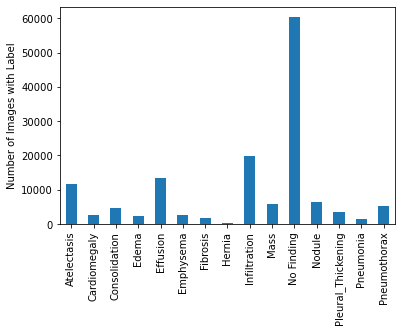

In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].map(lambda finding: 'Positive' if finding == 1.0 else 'Negative')
#all_xray_df.sample(3)

# Todo
# percentage of cases
labelCases = all_xray_df[all_labels].sum()*100/len(all_xray_df)
print(labelCases)

# plot the number of cases
ax = all_xray_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

## Create your training and testing data:

In [5]:
import sklearn.model_selection as skl

def create_splits(d):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Find percentage of pneumonia in dataset
    ratioPosPCasesInDS = len(d[d.Pneumonia == 1])/len(d)
    #print(len(d), len(posP), ratioPosPCasesInDS)    
    
    # 80:20 random split between training and validation such that % pneumonia is same in both sets 
    train_data, val_data = skl.train_test_split(d, test_size = 0.2, stratify = d['Pneumonia'])
    print(len(train_data), len(val_data))    

    # Ensure pneumonia vs non-pneumonia is 50-50 in training
    p_inds = train_data[train_data.Pneumonia==1].index.tolist()
    np_inds = train_data[train_data.Pneumonia==0].index.tolist()
    np_sample = sample(np_inds,len(p_inds))
    train_data = train_data.loc[p_inds + np_sample]    
    
    # Ensure pneumonia vs non-pneumonia is ratioPosPCasesInDS:(1-ratioPosPCasesInDS) in validation
    p_inds = val_data[val_data.Pneumonia==1].index.tolist()
    np_inds = val_data[val_data.Pneumonia==0].index.tolist()
    lenValNegP = int(len(p_inds)/ratioPosPCasesInDS - len(p_inds))
    np_sample = sample(np_inds,lenValNegP)
    val_data = val_data.loc[p_inds + np_sample]         
    print(len(val_data))    
    
    return train_data, val_data

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [6]:
from tensorflow.keras.applications.vgg16 import preprocess_input

def my_image_augmentation(forTraining):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    if forTraining:
        idg = ImageDataGenerator(rescale=None,
                                 preprocessing_function=preprocess_input,
                                 horizontal_flip = True, 
                                 vertical_flip = False, 
                                 height_shift_range= 0.1, 
                                 width_shift_range=0.1, 
                                 rotation_range=10, 
                                 shear_range = 0.1,
                                 zoom_range=0.1)
    else: # no augmentation for validation images
        idg = ImageDataGenerator(rescale=None,
                                 preprocessing_function=preprocess_input)

    return idg


def make_train_gen(train_data, batchSize):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
#     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
#                                          directory=None, 
#                                          x_col = ,
#                                          y_col = ,
#                                          class_mode = 'binary',
#                                          target_size = , 
#                                          batch_size = 
#                                          )
     # Todo
    idg = my_image_augmentation(True)
    
    IMG_SIZE = (224, 224)
    train_gen = idg.flow_from_dataframe(dataframe=train_data, 
                                        directory=None, 
                                        x_col = 'path',
                                        y_col = 'pneumonia_class',
                                        class_mode = 'binary',
                                        target_size = IMG_SIZE, 
                                        batch_size = batchSize
                                        )
    return train_gen


def make_val_gen(val_data, batchSize):
    idg = my_image_augmentation(False)
    
    IMG_SIZE = (224, 224)
    val_gen = idg.flow_from_dataframe(dataframe=val_data, 
                                        directory=None, 
                                        x_col = 'path',
                                        y_col = 'pneumonia_class',
                                        class_mode = 'binary',
                                        target_size = IMG_SIZE, 
                                        batch_size = batchSize
                                        )
    
    # Todo
    return val_gen

In [7]:
train_data, val_data = create_splits(all_xray_df)

train_gen = make_train_gen(train_data, 32)

89696 22424
22408
Found 2290 validated image filenames belonging to 2 classes.


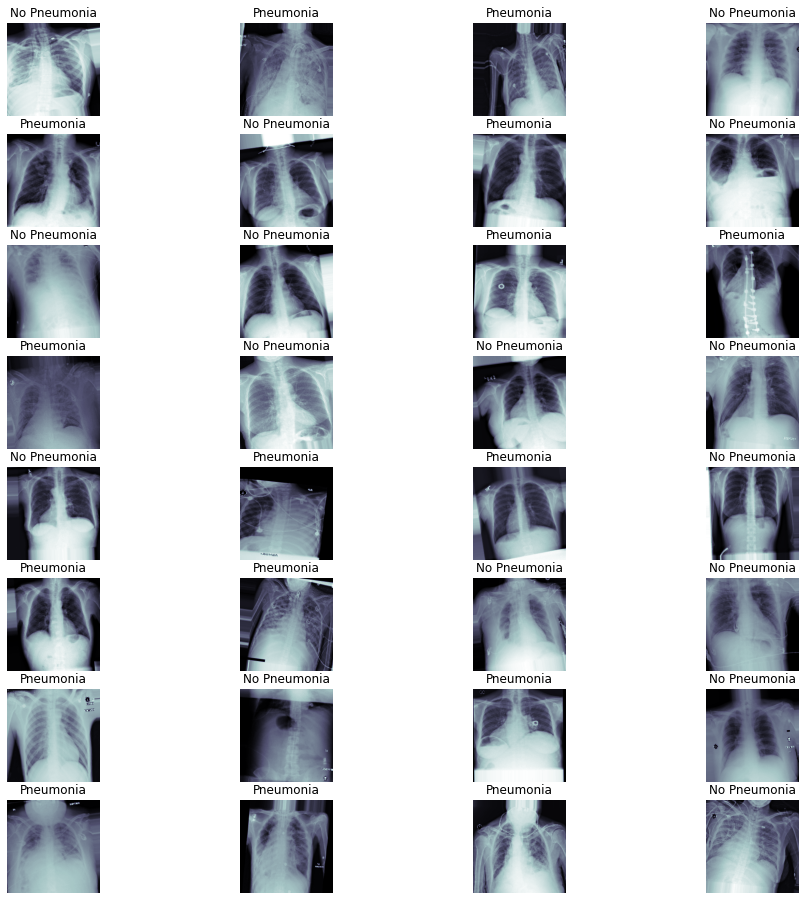

In [8]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(8, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [9]:
def load_pretrained_model():    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    ## Now, choose which layers of VGG16 we actually want to fine-tune (if any)
    ## Here, we'll freeze all but the last convolutional layer
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False    
    
    return vgg_model

In [10]:
def build_my_model(vgg_model):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    my_model = Sequential()

    # Add the convolutional part of the VGG16 model from above.
    my_model.add(vgg_model)

    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    my_model.add(Flatten())

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dropout(0.5))
    my_model.add(Dense(256, activation='relu'))
    
    # Final layer is a sigmoid
    my_model.add(Dense(1, activation='sigmoid'))
  
    ## Set our optimizer, loss function, and learning rate
    optimizer = Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return my_model

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [11]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list = [checkpoint, early]

#Also consider plotting the history of your model training:
def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

### Start training! 

553467904/553467096 [==============================] - 8s 0us/step
Found 22408 validated image filenames belonging to 2 classes.
Epoch 1/10
72/72 [==============================] - 450s 6s/step - loss: 2.8812 - binary_accuracy: 0.5493 - val_loss: 3.4059 - val_binary_accuracy: 0.1389

Epoch 00001: val_loss improved from inf to 3.40589, saving model to xray_class_my_model.best.hdf5
Epoch 2/10
72/72 [==============================] - 393s 5s/step - loss: 1.2994 - binary_accuracy: 0.5690 - val_loss: 0.4999 - val_binary_accuracy: 0.6356

Epoch 00002: val_loss improved from 3.40589 to 0.49994, saving model to xray_class_my_model.best.hdf5
Epoch 3/10
72/72 [==============================] - 389s 5s/step - loss: 0.7736 - binary_accuracy: 0.6017 - val_loss: 0.6709 - val_binary_accuracy: 0.4144

Epoch 00003: val_loss did not improve from 0.49994
Epoch 4/10
72/72 [==============================] - 394s 5s/step - loss: 0.6884 - binary_accuracy: 0.6109 - val_loss: 0.9226 - val_binary_accuracy: 0.39

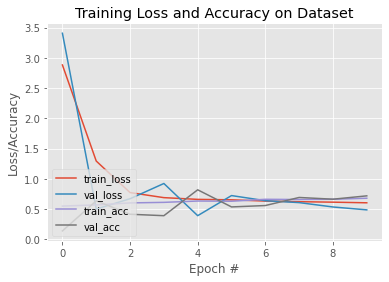

In [12]:
## train your model
from workspace_utils import active_session  
with active_session():    
    vgg_model = load_pretrained_model()
    my_model = build_my_model(vgg_model)
    history = my_model.fit_generator(train_gen, 
                                   validation_data = make_val_gen(val_data, 128), 
                                   epochs = 10, 
                                   callbacks = callbacks_list)
    plot_history(history)

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [17]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
vgg_model = load_pretrained_model()
my_model = build_my_model(vgg_model)
my_model.load_weights(weight_path)

from workspace_utils import active_session  
with active_session(): 
    val_gen = make_val_gen(val_data, 22000)
    valX, valY = val_gen.next()
    pred_Y = my_model.predict(valX, verbose = True)

Found 22408 validated image filenames belonging to 2 classes.
22000/22000 [==============================] - 196s 9ms/step


In [18]:
from sklearn.preprocessing import binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve
from sklearn.metrics import f1_score, confusion_matrix

def plot_auc(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')    
    return

def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')


def plot_f1Scores_Threshold(f1Scores, thresholds):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    c_ax.plot(thresholds, f1Scores, label = 'Pneumonia - threshold vs f1Scores')
    c_ax.legend()
    c_ax.set_xlabel('thresholds')
    c_ax.set_ylabel('f1Scores')
    
# function to calculate the F1 score
def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)

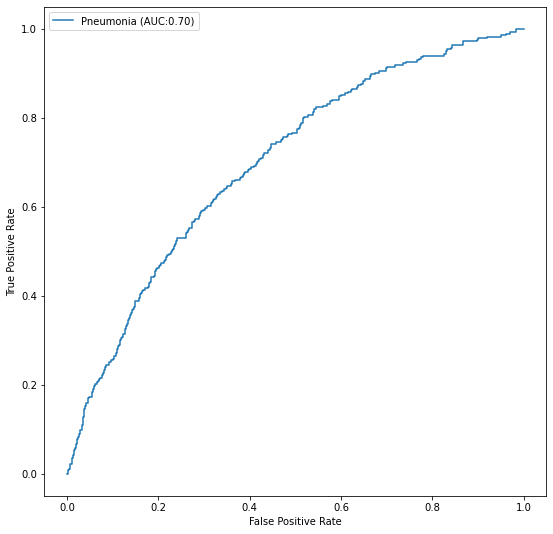

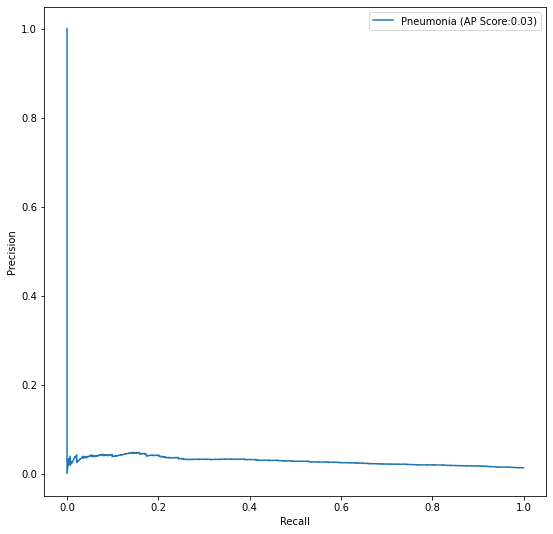

In [19]:
## plot figures
plot_auc(valY,pred_Y)
plot_precision_recall_curve(valY,pred_Y)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

Precision is: 0.04756380510440835
Recall is: 0.14487632508833923
Threshold is: 0.6390249
F1 Score is: 0.07161572052401746

Precision is: 0.01964021899713218
Recall is: 0.7985865724381626
Threshold is: 0.35562572
F1 Score is: 0.03833757421543681
Max f1 score is: 0.07317073170731707
Optimum threshold is: 0.6315384


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater_equal
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in less_equal


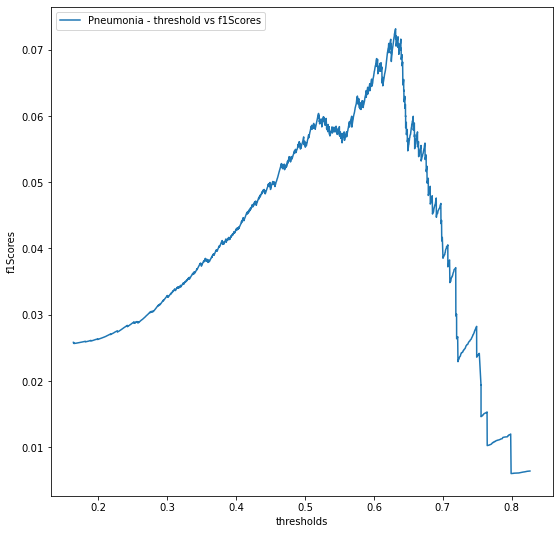

In [26]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.
precision, recall, thresholds = precision_recall_curve(valY,pred_Y)
#print(len(thresholds), len(precision))

# Look at the threshold where precision is 0.5
precision_value = 0.5
idx = (np.abs(precision - precision_value)).argmin() 
#print(idx)
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

print("")
# Look at the threshold where recall is 0.8
recall_value = 0.8
idx = (np.abs(recall - recall_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

f1Scores = calc_f1(precision[:-1],recall[:-1])
validF1ScoresIdx = np.where(np.logical_and(f1Scores>=0.0, f1Scores<=1.0))
validF1Scores = f1Scores[validF1ScoresIdx]
validThresholds = thresholds[validF1ScoresIdx]
maxf1score = np.max(validF1Scores)
print("Max f1 score is: " + str(maxf1score))
optimumThresholdIdx = np.argmax(validF1Scores)
OPT_THRESHOLD = validThresholds[optimumThresholdIdx]
print("Optimum threshold is: " + str(OPT_THRESHOLD))

plot_f1Scores_Threshold(validF1Scores, validThresholds)

Accuracy at threshold 0.6315384: 0.9481363636363637


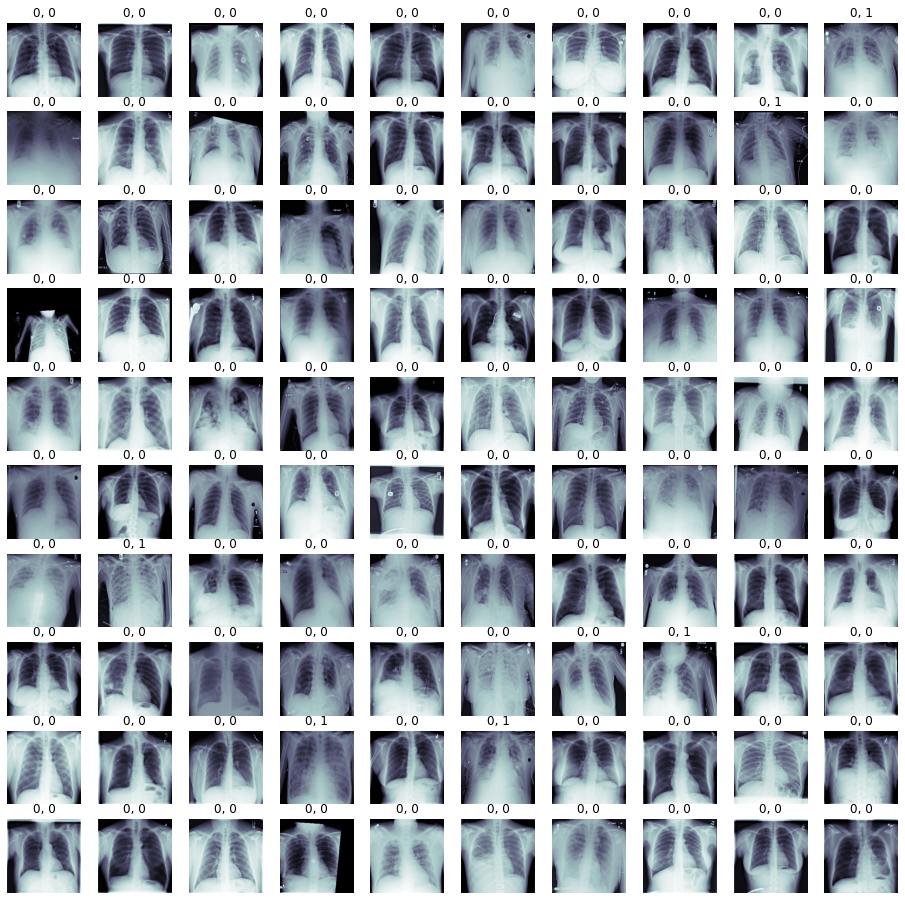

In [27]:
## Let's look at some examples of true vs. predicted with our best model: 
# F1 Scores are poor in all cases but score is higher where 
t1 = (pred_Y > OPT_THRESHOLD)
t1 = np.squeeze(t1.astype(int))
#print(t1.shape, valY.shape)
compare_t1 = (t1 == valY).astype(int)
print('Accuracy at threshold ' + str(OPT_THRESHOLD) + ': ' + str(np.sum(compare_t1)/len(pred_Y)))

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > OPT_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > OPT_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [28]:
## Just save model architecture to a .json:
model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)